# **Car Body Damage Detection**
### -Detect scratch, dent, repaint etc. on car body

### Source/Useful Links

For Segmentation: https://www.tensorflow.org/tutorials/images/segmentation

U-Net - https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/

U-Net++ - https://jinglescode.github.io/datascience/2019/12/02/biomedical-image-segmentation-u-net-nested/

Data Preprocessing:
1. https://towardsdatascience.com/cnn-application-detecting-car-exterior-damage-full-implementable-code-1b205e3cb48c

2. https://www.analyticsvidhya.com/blog/2018/07/building-mask-r-cnn-model-detecting-damage-cars-python/

Training and predictions: 
Google Colab https://colab.research.google.com/

In [1]:
# Using segmentation_models for image segmentation task, https://github.com/qubvel/segmentation_models
! pip install segmentation-models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 5.2 MB/s 


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!gdown 1Ev0YUTh3hkJXufUEAegyz7rREIuQd5Y_

Downloading...
From: https://drive.google.com/uc?id=1Ev0YUTh3hkJXufUEAegyz7rREIuQd5Y_
To: /content/png_png_512resize_dim3_multi_data220728.zip
100% 116M/116M [00:00<00:00, 188MB/s] 


In [6]:
!unzip /content/png_png_512resize_dim3_multi_data220728.zip

Archive:  /content/png_png_512resize_dim3_multi_data220728.zip
   creating: multi_mask_data/
   creating: multi_mask_data/images/
  inflating: multi_mask_data/images/a_042.png  
  inflating: multi_mask_data/images/c_42.png  
  inflating: multi_mask_data/images/b_0150.png  
  inflating: multi_mask_data/images/d_0285.png  
  inflating: multi_mask_data/images/b_0152.png  
  inflating: multi_mask_data/images/a_09.png  
  inflating: multi_mask_data/images/a_074.png  
  inflating: multi_mask_data/images/d_0252.png  
  inflating: multi_mask_data/images/b_0159.png  
  inflating: multi_mask_data/images/d_0223.png  
  inflating: multi_mask_data/images/b_0190.png  
  inflating: multi_mask_data/images/d_0259.png  
  inflating: multi_mask_data/images/b_0196.png  
  inflating: multi_mask_data/images/b_0169.png  
  inflating: multi_mask_data/images/a_079.png  
  inflating: multi_mask_data/images/a_03.png  
  inflating: multi_mask_data/images/b_0162.png  
  inflating: multi_mask_data/images/d_0246.png

In [8]:
import warnings
warnings.filterwarnings("ignore")

import os
import sys
import datetime
import IPython.display as display
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import pathlib
from PIL import Image
import numpy as np
#from tensorflow_examples.models.pix2pix import pix2pix
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

import tensorflow as tf
AUTOTUNE = tf.data.experimental.AUTOTUNE
from datetime import datetime
from tensorflow.python.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import *
from tensorflow.keras import regularizers, layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K

from IPython.display import clear_output
import matplotlib.pyplot as plt
AUTOTUNE = tf.data.experimental.AUTOTUNE
from sklearn.model_selection import train_test_split

# for TensorBoard
from __future__ import absolute_import, division, print_function, unicode_literals
%tensorflow_version 2.x

import segmentation_models
print(segmentation_models.__version__)

import segmentation_models as sm

# Root directory of the project
ROOT_DIR = os.path.abspath("/content/multi_mask_data")
# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
# Path to trained weights file
COCO_WEIGHTS_PATH = os.path.join("/content/mask_rcnn_coco.h5")

# Directory to save logs and model checkpoints, if not provided
# through the command line argument --logs
DEFAULT_LOGS_DIR = os.path.join(ROOT_DIR, "logs")

1.0.1


In [9]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


## 4. **Data preparation**

In [10]:
def display1(display_list):
  plt.figure(figsize=(8, 8))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

In [11]:
def create_mask(pred_mask):
  '''
  as predicted mask has 4dim with bacth size we need to remove that
  tf.argmax Returns the index with the largest value across axes of a tensor.
  '''
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [12]:
def show_predictions(dataset=None, num=3):
  '''
  Takes input image and predicts mask and plots the Input, True, Predicted images
  '''
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display1([image[0], mask[0], create_mask(pred_mask)])
  else:
    display1([sample_image, sample_mask,
             model.predict(sample_image[tf.newaxis, ...])[0]])

### Tfdata Generator

In [13]:
TRAIN_LENGTH = 44
BATCH_SIZE = 8
BUFFER_SIZE = 100
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
OUTPUT_CHANNELS = 3

In [14]:
!pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [15]:
import splitfolders
splitfolders.ratio ('/content/multi_mask_data', output = '/content/dataset', seed = 777, ratio = (0.8, 0.1, 0.1)) 

Copying files: 762 files [00:00, 2989.54 files/s]


In [16]:
data_root = pathlib.Path("/content/dataset/train")
val_data_root = pathlib.Path("/content/dataset/val")
print(data_root, val_data_root)

/content/dataset/train /content/dataset/val


In [17]:
##Getting all image paths
import random

all_image_paths = list(data_root.glob('images/*'))
all_image_paths = [str(path) for path in all_image_paths]

all_mask_paths = list(data_root.glob('masks/*'))
all_mask_paths = [str(path) for path in all_mask_paths]

val_all_image_paths = list(val_data_root.glob('images/*'))
val_all_image_paths = [str(path) for path in val_all_image_paths]

val_all_mask_paths = list(val_data_root.glob('masks/*'))
val_all_mask_paths = [str(path) for path in val_all_mask_paths]

# ##shuffling the images 
# random.shuffle(all_image_paths)

print("image_count = ", len(all_image_paths), ", mask_count = ", len(all_mask_paths))
print("val_image_count = ", len(val_all_image_paths), ", val_mask_count = ", len(val_all_mask_paths))

image_count =  304 , mask_count =  304
val_image_count =  38 , val_mask_count =  38


In [19]:
def tfdata_generator(images, mask, is_training, batch_size=1):
    '''Construct a data generator using tf.Dataset'''
    
    def parse_function(filename, mask):
        #reading path 
        image_string = tf.io.read_file(filename)
        mask_string = tf.io.read_file(mask)
        
        #decoding image
        image = tf.image.decode_jpeg(image_string, channels=3)
        mask = tf.image.decode_jpeg(mask_string, channels=3)

        # This will convert to float values in [0, 1]
        image = tf.image.convert_image_dtype(image, tf.float32)
        mask = tf.image.convert_image_dtype(mask, tf.float32)
        
        #resize the image
        image = tf.image.resize(image, [512, 512])
        mask = tf.image.resize(mask, [512, 512])
        
        image = tf.image.resize_with_crop_or_pad(image, 512, 512) # Add 6 pixels of padding
        image = tf.image.random_crop(image, size=[512, 512, 3], seed = 1) # Random crop back to 512X512
        #image = tf.image.random_brightness(image, max_delta=0.5, seed = 1)
        image = tf.image.random_flip_left_right(image, seed=1)
        image = tf.image.random_flip_up_down(image, seed=1)
        #image = tf.image.random_jpeg_quality(image, 90, 100, seed=1)

        mask = tf.image.resize_with_crop_or_pad(mask, 512, 512) # Add 6 pixels of padding
        mask = tf.image.random_crop(mask, size=[512, 512, 3], seed = 1) # Random crop back to 512X512
        #mask = tf.image.random_brightness(mask, max_delta=0.5, seed = 1)
        mask = tf.image.random_flip_left_right(mask, seed=1)
        mask = tf.image.random_flip_up_down(mask, seed=1)
        #mask = tf.image.random_jpeg_quality(mask, 90, 100, seed=1)

        #image, mask = normalize(image, mask)
        return image, mask
    
    ##creating a dataset from tensorslices
    dataset = tf.data.Dataset.from_tensor_slices((images, mask))
    
    if is_training:
        dataset = dataset.shuffle(100)  # depends on sample size

    # Transform and batch data at the same time
    dataset = dataset.apply(tf.data.experimental.map_and_batch( parse_function, batch_size, num_parallel_batches=32,  # cpu cores
        drop_remainder=True if is_training else False))
    
    #repeat the dataset indefinitely
    dataset = dataset.repeat()

    
    #prefetch the data into CPU/GPU
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

    return dataset


In [20]:
#creating a generator
tf_image_generator = tfdata_generator(all_image_paths, all_mask_paths, is_training=True, batch_size=BATCH_SIZE)
val_tf_image_generator = tfdata_generator(val_all_image_paths, val_all_mask_paths, is_training=True, batch_size=4)
tf_image_generator

Instructions for updating:
Use `tf.data.Dataset.map(map_func, num_parallel_calls)` followed by `tf.data.Dataset.batch(batch_size, drop_remainder)`. Static tf.data optimizations will take care of using the fused implementation.


<PrefetchDataset element_spec=(TensorSpec(shape=(8, 512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(8, 512, 512, 3), dtype=tf.float32, name=None))>

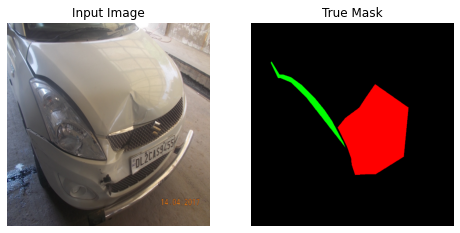

In [21]:
for image, mask in val_tf_image_generator.take(5):
  sample_image, sample_mask = image[0], mask[0]
display1([sample_image, sample_mask])

## 5. Define Custom model

<img src="images/Nested_Unet.PNG">

In [22]:
#https://jinglescode.github.io/datascience/2019/12/02/biomedical-image-segmentation-u-net-nested/
#Unet++

class conv_block_nested(tf.keras.Model):

    def __init__(self, in_ch):
        super(conv_block_nested, self).__init__()
        self.activation = layers.Activation('relu')
        self.conv1 = layers.Conv2D(in_ch, 3, padding='same')
        self.bn1 = layers.BatchNormalization()
        self.conv2 = layers.Conv2D(in_ch, 3, padding='same')
        self.bn2 = layers.BatchNormalization()

    def call(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.activation(x)

        x = self.conv2(x)
        x = self.bn2(x)
        output = self.activation(x)

        return output

class Nested_UNet(tf.keras.Model):

    def __init__(self, out_ch=3):
        super(Nested_UNet, self).__init__()

        n1 = 32
        filters = [n1, n1 * 2, n1 * 4, n1 * 8, n1 * 16]

        self.pool = layers.MaxPooling2D(3, strides=2, padding='same') #2 or 3 ?
        self.Up = layers.UpSampling2D(2)

        self.conv0_0 = conv_block_nested(filters[0])
        self.conv1_0 = conv_block_nested(filters[0])
        self.conv2_0 = conv_block_nested(filters[1])
        self.conv3_0 = conv_block_nested(filters[2])
        self.conv4_0 = conv_block_nested(filters[3])

        self.conv0_1 = conv_block_nested(filters[0])
        self.conv1_1 = conv_block_nested(filters[1])
        self.conv2_1 = conv_block_nested(filters[2])
        self.conv3_1 = conv_block_nested(filters[3])

        self.conv0_2 = conv_block_nested(filters[0])
        self.conv1_2 = conv_block_nested(filters[1])
        self.conv2_2 = conv_block_nested(filters[2])

        self.conv0_3 = conv_block_nested(filters[0])
        self.conv1_3 = conv_block_nested(filters[1])

        self.conv0_4 = conv_block_nested(filters[0])

        self.final = tf.keras.layers.Conv2D(out_ch, 3, activation='sigmoid', padding='same')

    def call(self, x):
        
        x0_0 = self.conv0_0(x)
        x1_0 = self.conv1_0(self.pool(x0_0))
        x0_1 = self.conv0_1(tf.keras.layers.concatenate([x0_0, self.Up(x1_0)]))

        x2_0 = self.conv2_0(self.pool(x1_0))
        x1_1 = self.conv1_1(tf.keras.layers.concatenate([x1_0, self.Up(x2_0)]))
        x0_2 = self.conv0_2(tf.keras.layers.concatenate([x0_0, x0_1, self.Up(x1_1)]))

        x3_0 = self.conv3_0(self.pool(x2_0))
        x2_1 = self.conv2_1(tf.keras.layers.concatenate([x2_0, self.Up(x3_0)]))
        x1_2 = self.conv1_2(tf.keras.layers.concatenate([x1_0, x1_1, self.Up(x2_1)]))
        x0_3 = self.conv0_3(tf.keras.layers.concatenate([x0_0, x0_1, x0_2, self.Up(x1_2)]))

        x4_0 = self.conv4_0(self.pool(x3_0))
        x3_1 = self.conv3_1(tf.keras.layers.concatenate([x3_0, self.Up(x4_0)]))
        x2_2 = self.conv2_2(tf.keras.layers.concatenate([x2_0, x2_1, self.Up(x3_1)]))
        x1_3 = self.conv1_3(tf.keras.layers.concatenate([x1_0, x1_1, x1_2, self.Up(x2_2)]))
        x0_4 = self.conv0_4(tf.keras.layers.concatenate([x0_0, x0_1, x0_2, x0_3, self.Up(x1_3)]))

        output = self.final(x0_4)
        
        return output

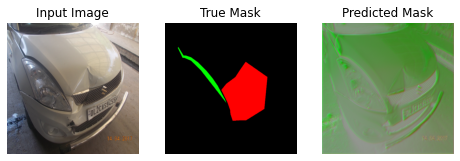

Model: "nested_u_net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 max_pooling2d (MaxPooling2D  multiple                 0         
 )                                                               
                                                                 
 up_sampling2d (UpSampling2D  multiple                 0         
 )                                                               
                                                                 
 conv_block_nested (conv_blo  multiple                 10400     
 ck_nested)                                                      
                                                                 
 conv_block_nested_1 (conv_b  multiple                 18752     
 lock_nested)                                                    
                                                                 
 conv_block_nested_2 (conv_b  multiple                

In [23]:
tf.keras.backend.clear_session()
model = Nested_UNet(3)
model.compile()
show_predictions()
model.summary()

In [24]:
class DisplayCallback(tf.keras.callbacks.Callback):
  '''
  To check the predicted mask at each epoch
  '''
  def on_epoch_end(self, epoch, logs=None):
    #clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [25]:
# Metrics
# For image segmentation
# COMPETITION METRIC
# https://www.kaggle.com/xhlulu/severstal-simple-keras-u-net-boilerplate
def dice_coef(y_true, y_pred, smooth=K.epsilon()):
    '''
    This function returns dice coefficient of similarity between y_true and y_pred
    Dice coefficient is also referred to as F1_score, but we will use this name for image segmentation models
    For example, 
    let an instance on y_true and y_pred be [[1,1],[0,1]] and [[1,0],[0,1]]
    this metric first converts the above into [1,1,0,1] abd [1,0,0,1],
    then intersection is calculated as 1*1 + 1*0 + 0*1 + 1*1 = 2 and sum(y_true)+sum(y_pred)= 3+2 = 5
    this returns the value (2.* 2 + 10e-7)/(3 + 2 + 10e-7) ~ 0.8    
    '''
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    
    
dependencies = {'dice_coef':dice_coef,
    'dice_loss':sm.losses.dice_loss }

### Compile and fit the model

In [26]:
# https://www.tensorflow.org/tensorboard/r2/scalars_and_keras
logdir = '/content/' + datetime.now().strftime("%Y%m%d-%H%M%S")+'_damage_2020'
file_writer = tf.summary.create_file_writer(logdir + "/metrics")
tensorboard = tf.keras.callbacks.TensorBoard(log_dir=logdir,histogram_freq=0,write_images=True)
#train_writer = tf.summary.create_file_writer('./logs/1/train')
# https://keras.io/callbacks/
mc = ModelCheckpoint(filepath = ROOT_DIR +'/car_damage_new.h5', monitor='val_dice_coef', mode='max', verbose=1, save_best_only=True)
#earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_dice_coef', patience=10)

In [27]:
model = Nested_UNet(OUTPUT_CHANNELS)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(optimizer=optimizer, loss=sm.losses.dice_loss, metrics=[dice_coef])

In [28]:
EPOCHS = 100
VAL_SUBSPLITS = 5
VALIDATION_STEPS = 5//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit_generator(tf_image_generator, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=val_tf_image_generator,
                          callbacks=[DisplayCallback(), mc, tensorboard])

Epoch 1/100


ResourceExhaustedError: ignored

### Plotting Losses

### TensorBoard

<img src="images/tensorboard_unet++.PNG">

Sample predictions



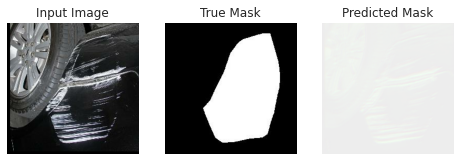

In [ ]:
# Loading best model
model = Nested_UNet(OUTPUT_CHANNELS)
model.compile(optimizer=optimizer, loss=sm.losses.dice_loss, metrics=[dice_coef])
print('Sample predictions\n')
show_predictions()
model.load_weights('/content/drive/My Drive/Colab Notebooks/CS2/references/car_damage_new.h5')

In [ ]:
# Save the entire model as a SavedModel.
model.save('/content/drive/My Drive/Colab Notebooks/CS2/references/car_damage_final_Nested_unet5')

INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/CS2/references/car_damage_final_Nested_unet4/assets


In [ ]:
model = load_model('/content/drive/My Drive/Colab Notebooks/CS2/references/car_damage_final_Nested_unet4', custom_objects=dependencies)

## 6. Predictions

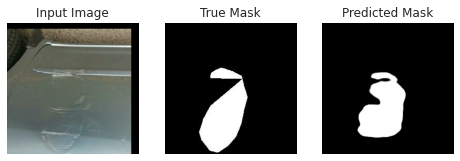

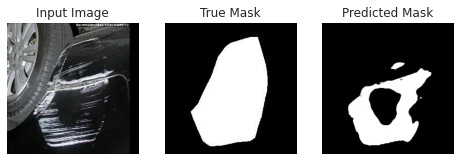

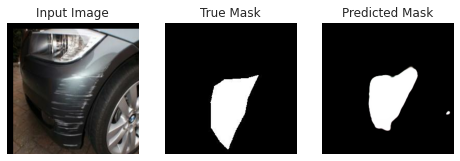

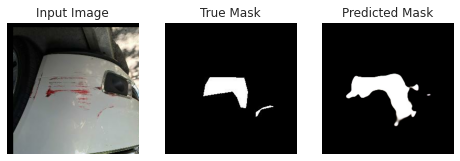

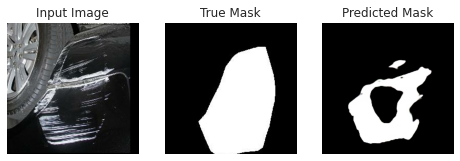

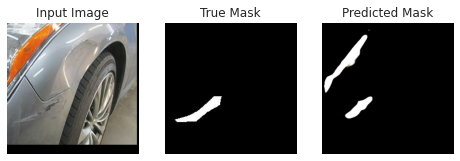

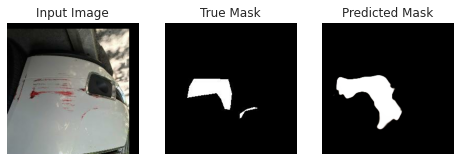

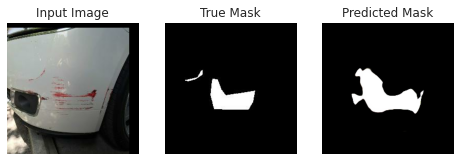

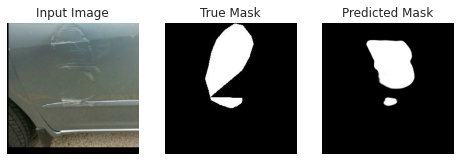

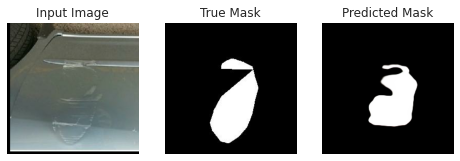

In [ ]:
for image, mask in val_tf_image_generator.take(10):
  sample_image, sample_mask = image[0], mask[0]
  display1([sample_image, sample_mask,
         model.predict(sample_image[tf.newaxis, ...])[0]])

### Model comparsions

In [ ]:
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["Model Name", "train_dice_coef", "val_dice_coef"]

x.add_row(["U-Net", '0.89', '0.72'])
x.add_row(["Modified U-Net", '0.87', '0.76'])
x.add_row(["U-Net++", '0.87', '0.75'])
print(x)

+----------------+-----------------+---------------+
|   Model Name   | train_dice_coef | val_dice_coef |
+----------------+-----------------+---------------+
|     U-Net      |       0.89      |      0.72     |
| Modified U-Net |       0.87      |      0.76     |
|    U-Net++     |       0.87      |      0.75     |
+----------------+-----------------+---------------+


## 7. Conclusions and Future Research

1. I have experimented with U-net, modified U-net and U-net++ model for training on samll dataset (55 total images) which is giving good predictions.

2. Compared to U-net U-net++ and modified U-net are giving good predictions and the val_dice_coef curve is smooth.

3. Model trained on U-net architecture is highly overfitting compared to other models

4. Since the dataset is small we have to use datagenerator to improve performance and avoid overfitting.

5. Due to time constraint i was not unable to collect more images and do proper data preprocessing like masking damages properly, removing unnecesary images and croping to make the damage clear as ther are some full car pictures.

6. we can also try some of the techniques described in the tenosr flow tutorials
https://www.tensorflow.org/tutorials/keras/overfit_and_underfit to avoid overfit